In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import ipyvuetify as v
import ipywidgets as ipw
import warnings

warnings.filterwarnings("ignore") #UI can get messed up if any warnings come up.

In [2]:
# Dummy globals
current_df = None
current_dataset = None

In [3]:
# Read in data
climate_change_indicators = pd.read_csv("data/climate-change_mdg.csv")
food_security = pd.read_csv("data/food_security/pblstatssum-2.csv")
climate_data=pd.read_csv('data/madagascar_temp_data.csv')

In [4]:
# Constants and option definitions

time_col={"Climate Change Indicators":"Year", "Food Security":"SvyDate", "Climate Data":"YEAR"}
v.theme.dark = False

LIST_DATASETS =  ['No Dataset Selected', 
        'Climate Data',
        'Climate Change Indicators',
        'Food Security']

MAPPING_DATASETS = {
    'Climate Data':climate_data,
    'Climate Change Indicators':climate_change_indicators,
    'Food Security':food_security
}

MAPPING_INDICATORS = {
    'Climate Data':'YEAR',
    'Climate Change Indicators':'Indicator Name',
    'Food Security':'Variable'
}

MAPPING_VALUES = {
    'Climate Data':None,
    'Climate Change Indicators':'Value',
    'Food Security':'Mean'
}

MAPPING_GRAPH_TYPES = {
    'Climate Data':["Line", "Scatter"],
    'Climate Change Indicators':["Line", "Scatter"],
    'Food Security':["Bar"]
}
          
MONTHS = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [5]:
#user selects the frequency of the given data
dataset_picker = v.Select(
    items=LIST_DATASETS, 
    v_model='No Dataset Selected',
    label="Select a category",
    disabled=False,
)

topic_picker_items = ["Please Select Category"]
topic_picker = v.Select(
    items=topic_picker_items, 
    v_model=topic_picker_items[0],
    label="Select a topic",
    disabled=True,
)

graph_type_items = ["Please Select Category"]
graph_type = v.Select(
    items=graph_type_items, 
    v_model=graph_type_items[0],
    label="Select a graph type",
    disabled=True,
)


#button to display forecast
display_visualize_btn = v.Btn(
    color="success",
    class_='ma-2',
    children=[
        v.Icon(left=True, children=[
            'mdi-chart-timeline-variant'
        ]),
        'Display Visualization'
    ],
    disabled=True
)

figure_display_area = ipw.Output(
    layout={
        'align-items':'center'
    },
)

upload_caption_area = ipw.Output(
    layout={
        'align-items':'left'
    }
)

hidden_dl_link_area = ipw.Output()

# All the plots and output go here
display_col = v.Col(
    tag='div',
    cols=9,
    children=[
        figure_display_area
    ]
)

# All the controls are in one column
#TODO: maybe add in the export_btn later
upload_caption = ""
controls_col = v.Col(
    tag='div',
    cols=3,
    children=[
        dataset_picker,
        topic_picker,
        graph_type,
        display_visualize_btn
    ]
)

# Everything together in a row
full_display = v.Row(
    tag='div',
    fluid=True,
    children=[
        controls_col,
        display_col
    ]
)

In [6]:

# Graphics/UI and direct handler functions

def render():
    """
    Becuase the content of some UI elements depends on the settings in others,
    the UI needs to be re-displayed whenever something is changed.
    
    This gets called once at program start, and then again after every setting change.
    """
    
    display(upload_caption_area)
    display(hidden_dl_link_area)
    display(full_display)

def on_change():
    """
    Called whenever any UI element is changed.
    
    Responsible for changing active_series, an identifier (file and column name) for the series of interest.
    Also responsible for calling render().
    """
    render()
    
            
def display_visualize_on_click(widget, event, data):
    global current_df
    global current_dataset
    global topic_picker
    
    if (dataset_picker.v_model=="Climate Data"):
        show_plot_climate_data()
    
    else:
        indicator_name = MAPPING_INDICATORS[dataset_picker.v_model]
        time_column = time_col[dataset_picker.v_model]
        value_column = MAPPING_VALUES[dataset_picker.v_model]

        current_df = current_dataset[current_dataset[indicator_name]==topic_picker.v_model]
        current_df[value_column] = current_df[value_column].astype(float)

        try:
            show_visualize_plot()

        except Exception as e:
            with figure_display_area:
                print("An error occurred during visualization:\n", str(e))
                
def show_plot_climate_data():
    indicator_name = MAPPING_INDICATORS[dataset_picker.v_model]
    current_df = current_dataset[current_dataset[indicator_name]==topic_picker.v_model]
    lst = [current_df["JAN"].values[0], current_df["FEB"].values[0], current_df["MAR"].values[0], current_df["APR"].values[0], current_df["MAY"].values[0], current_df["JUN"].values[0], current_df["JUL"].values[0], current_df["AUG"].values[0], current_df["SEP"].values[0], current_df["OCT"].values[0], current_df["NOV"].values[0], current_df["DEC"].values[0]]
    if (graph_type.v_model=="Line"):
        plt.plot(MONTHS, lst)
    elif (graph_type.v_model=="Scatter"):
        plt.plot(MONTHS, lst, 'ro')
    plt.xlabel("Months")
    plt.ylabel("Temperature in Celsius")
    plt.title("Temperature for the year "+str(topic_picker.v_model))
    

In [7]:
def show_visualize_plot():
    global current_df
    global topic_picker
    global graph_type
    
    indicator_name = MAPPING_INDICATORS[dataset_picker.v_model]
    time_column = time_col[dataset_picker.v_model]
    value_column = MAPPING_VALUES[dataset_picker.v_model]
    
    with figure_display_area:
        if (dataset_picker.v_model == "Food Security"):
            title_to_assign = topic_picker.v_model + " as a function of region"
            y_label_to_assign = current_df["VariableDescription"].values[0]
            graph = sns.catplot(x="AdminStrata", y=value_column, kind=graph_type.v_model.lower(), data=current_df)
            graph.set(ylabel=y_label_to_assign, xlabel="Region", title=title_to_assign)
        
        else:
            current_df[time_column] = current_df[time_column].astype(float)
            

            title_to_assign = topic_picker.v_model + " as a function of time"

            graph = sns.relplot(data=current_df, x=time_column, y=value_column, kind=graph_type.v_model.lower())
            graph.set(ylabel=topic_picker.v_model, title=title_to_assign)
        
def select_dataset(change):
    global current_dataset
    global dataset_picker
    global topic_picker
       
    # Allox the user to export data if they have selected a dataset
    if (dataset_picker.v_model != 'No Dataset Selected'):
        display_visualize_btn.disabled=False
        current_dataset = MAPPING_DATASETS[dataset_picker.v_model]
    if (dataset_picker.v_model == 'No Dataset Selected'):
        display_visualize_btn.disabled=True 
        topic_picker.disabled = True
        graph_type.disabled = True
        return;
        
        
    topic_picker.disabled = False
    topic_picker.items = current_dataset[MAPPING_INDICATORS[dataset_picker.v_model]].unique()[1:].tolist()
    topic_picker.v_model = topic_picker.items[0]
     
    graph_type.disabled = False
    graph_type.items = MAPPING_GRAPH_TYPES[dataset_picker.v_model]
    graph_type.v_model = graph_type.items[0]
    

Output()

Output()

Row(children=[Col(children=[Select(disabled=False, items=['No Dataset Selected', 'Climate Data', 'Climate Chan…

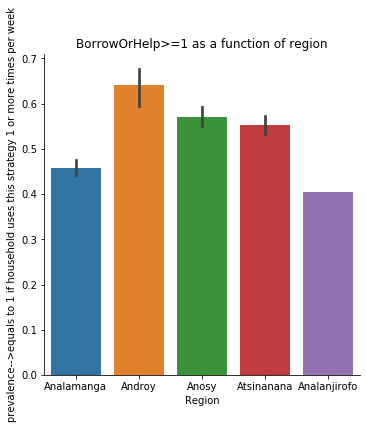

In [10]:
# Configure on_click and on_change behaviors
display_visualize_btn.on_event('click', display_visualize_on_click)
dataset_picker.observe(select_dataset, 'v_model')

render()